In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
df = pd.read_csv("21-housing.csv")

In [13]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [17]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [20]:
columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
           'median_house_value', 'ocean_proximity']

In [22]:
def find_outliers_iqr(df, threshold = 1.5):
    outlier_summary = {}
    numeric_cols = df.select_dtypes(include=["float64","int64"]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_summary[col] = {
            "outlier_count": outliers.shape[0],
            "outlier_percentage": 100 * outliers.shape[0] / df.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }
    return pd.DataFrame(outlier_summary)

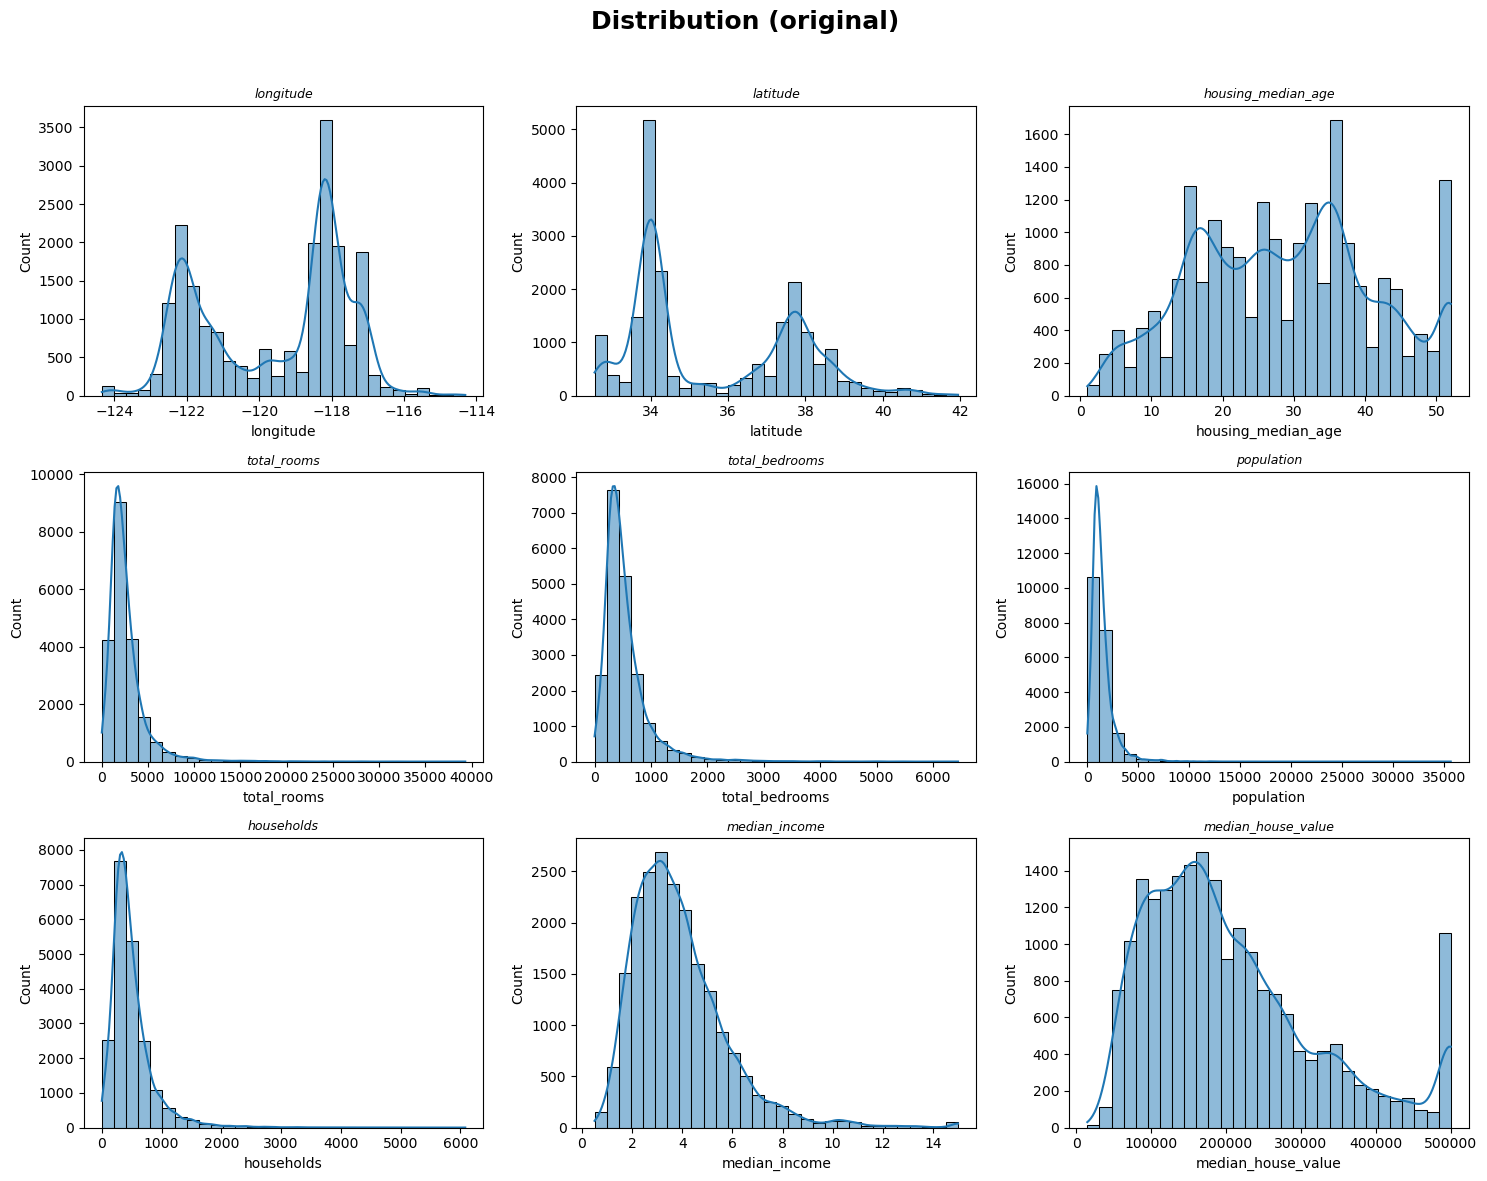

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
fig.suptitle("Distribution (original)", fontsize=18, fontweight="bold")
for i, col in enumerate(columns[:9]):
    row = i // 3
    col_idx = i % 3
    ax = axes[row, col_idx]
    sns.histplot(data=df, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(col, fontsize=9, fontstyle="italic")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [26]:
cols_to_clean = [
    "median_house_value",   # target
    "total_rooms",
    "total_bedrooms",
    "population",
    "households"
]

In [28]:
def remove_outliers_from_column(df, target_col, threshold = 1.5):
    # (DÜZELTME: parametre target_col olarak kullanılıyor, 'col' değil)
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)].copy()


In [30]:
def remove_outliers_from_all_columns(df):
    df_clean = df.copy()
    for col in cols_to_clean:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)].copy()
    return df_clean


In [32]:
print("original data shape:", df.shape)
df_target_clean = remove_outliers_from_column(df, "median_house_value")
print("only target column cleaning shape:", df_target_clean.shape)
df_all_clean = remove_outliers_from_all_columns(df)
print("all columns cleaning shape:", df_all_clean.shape)

original data shape: (20640, 10)
only target column cleaning shape: (19569, 10)
all columns cleaning shape: (17040, 10)


In [34]:
# Eğer total_bedrooms gibi kolonlarda NaN varsa doldur
df_all_clean["total_bedrooms"] = df_all_clean["total_bedrooms"].fillna(df_all_clean["total_bedrooms"].median())

In [36]:
from scipy.stats import boxcox

In [38]:
cols_to_transform = [
    "total_rooms",
    "total_bedrooms",
    "population",
    "households"
]

In [40]:
# NOT: burada transformasyon tüm df_all_clean üzerinde yapılıyor.
# Daha doğru yaklaşım: train üzerinde fit edip test'e uygulamak (aşağıda önerilerde belirtilir).
boxcox_lambdas = {}  # lambda değerlerini saklamak için
for col in cols_to_transform:
    # Pozitiflik kontrolü
    arr = df_all_clean[col].fillna(0).values
    # boxcox requires strictly positive -> add 1 (veya küçük sabit)
    transformed, lmbda = boxcox(arr + 1.0)
    df_all_clean[col] = transformed
    boxcox_lambdas[col] = lmbda

In [42]:
print("Feature boxcox lambdas:", boxcox_lambdas)
print(df_all_clean[cols_to_transform].describe())

Feature boxcox lambdas: {'total_rooms': 0.6145137148774971, 'total_bedrooms': 0.6590698854343894, 'population': 0.6623474438006113, 'households': 0.6950125665433384}
        total_rooms  total_bedrooms    population    households
count  17040.000000    17040.000000  17040.000000  17040.000000
mean     170.979002       78.548806    154.798487     88.909160
std       55.517691       26.132205     52.415012     30.761831
min        1.569133        1.612569      2.271918      1.648717
25%      135.111269       61.139355    120.034265     68.640765
50%      169.090989       77.447866    153.355124     87.889537
75%      207.392455       96.381878    190.683580    109.945096
max      327.376472      147.812099    285.011233    162.961308


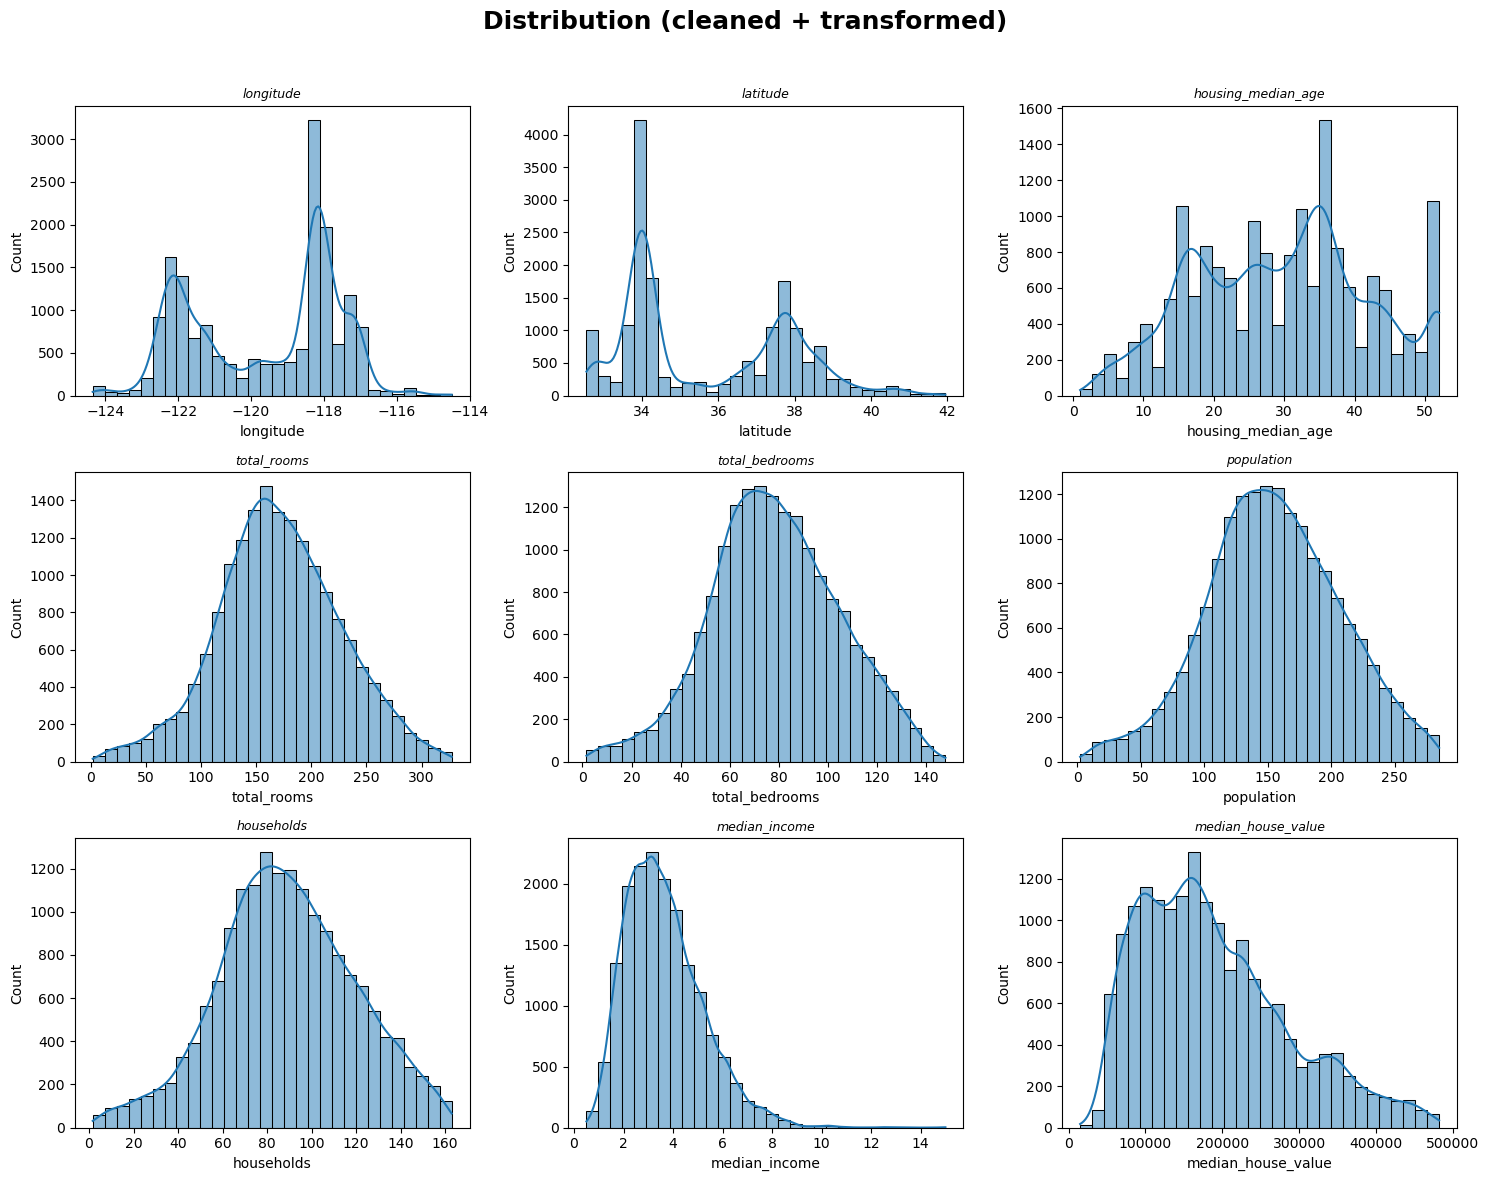

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
fig.suptitle("Distribution (cleaned + transformed)", fontsize=18, fontweight="bold")
for i, col in enumerate(columns[:9]):
    row = i // 3
    col_idx = i % 3
    ax = axes[row, col_idx]
    sns.histplot(data=df_all_clean, x=col, kde=True, ax=ax, bins=30)
    ax.set_title(col, fontsize=9, fontstyle="italic")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [46]:
categorical_cols = ["ocean_proximity"]
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

In [48]:
X = df_all_clean.drop("median_house_value", axis=1)
y = df_all_clean["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

In [50]:
models = {
    "Linear Regression" : LinearRegression(),
    "Lasso" : Lasso(),
    "Ridge" : Ridge(),
    "K Neighbors Regressor" : KNeighborsRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Random Forest Regressor" : RandomForestRegressor(),
    "Adaboost Regressor" : AdaBoostRegressor(),
    "Gradient Boost Regressor" : GradientBoostingRegressor(),
    "XGBoost Regressor" : XGBRegressor()
}


In [52]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [54]:
print("\n--- MODELLER (features transformed, target NOT transformed) ---")
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    print(name)
    print("Train RMSE:", train_rmse, " Test RMSE:", test_rmse)
    print("-"*30)



--- MODELLER (features transformed, target NOT transformed) ---
Linear Regression
Train RMSE: 57197.3877385043  Test RMSE: 57802.584646293275
------------------------------
Lasso
Train RMSE: 57197.41425055965  Test RMSE: 57802.2167118141
------------------------------
Ridge
Train RMSE: 57200.494611171736  Test RMSE: 57796.23073795745
------------------------------
K Neighbors Regressor
Train RMSE: 66493.00306478539  Test RMSE: 82030.54084536956
------------------------------
Decision Tree
Train RMSE: 0.0  Test RMSE: 63444.33976980829
------------------------------
Random Forest Regressor
Train RMSE: 16704.574860276112  Test RMSE: 43851.68327414332
------------------------------
Adaboost Regressor
Train RMSE: 75186.29031012137  Test RMSE: 76109.57782823806
------------------------------
Gradient Boost Regressor
Train RMSE: 47562.16825632234  Test RMSE: 49224.74549859476
------------------------------
XGBoost Regressor
Train RMSE: 23200.470629225383  Test RMSE: 41642.9554536035
--------

In [55]:
y_train_transformed, lambda_y = boxcox(y_train.values + 1.0)

# inverse fonksiyonu (biz +1 eklediğimiz için -1 ile geri alıyoruz)
def inverse_boxcox(y, lambda_):
    if lambda_ == 0:
        return np.exp(y) - 1.0
    else:
        return np.power(y * lambda_ + 1.0, 1.0 / lambda_) - 1.0


In [58]:
pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", LinearRegression())])
pipe.fit(X_train, y_train_transformed)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('model', LinearRegression())])

In [60]:
y_train_pred_transformed = pipe.predict(X_train)
y_train_pred_original = inverse_boxcox(y_train_pred_transformed, lambda_y)

In [62]:
y_test_pred_transformed = pipe.predict(X_test)
y_test_pred_original = inverse_boxcox(y_test_pred_transformed, lambda_y)

In [64]:
train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred_original)
test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred_original)
print("\n--- LinearRegression with target boxcox (y transformed) ---")
print("Train RMSE:", train_rmse)
print("Test RMSE :", test_rmse)


--- LinearRegression with target boxcox (y transformed) ---
Train RMSE: 57633.35884203359
Test RMSE : 61057.51016668955


In [90]:
df2 = pd.read_csv("21-housing.csv")

In [92]:
df2.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [94]:
df2["total_bedrooms"] = df2["total_bedrooms"].fillna(df2["total_bedrooms"].median())

In [96]:
df2.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [98]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# X ve y (HAM veri)
X2 = df2.drop("median_house_value", axis=1)
y2= df2["median_house_value"]

# Train / Test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=15)

# Categorical column
categorical_cols = ["ocean_proximity"]

# One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

# Pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Modeli eğit
pipeline.fit(X2_train, y2_train)

# Tahminler
y2_train_pred = pipeline.predict(X2_train)
y2_test_pred = pipeline.predict(X2_test)

# Değerlendirme fonksiyonu
def evaluate_model(y2_true, y2_pred):
    mae = mean_absolute_error(y2_true, y2_pred)
    rmse = np.sqrt(mean_squared_error(y2_true, y2_pred))
    r2 = r2_score(y2_true, y2_pred)
    return mae, rmse, r2

# Sonuçlar
train_mae, train_rmse, train_r2 = evaluate_model(y2_train, y2_train_pred)
test_mae, test_rmse, test_r2 = evaluate_model(y2_test, y2_test_pred)

print("BASELINE MODEL (NO TRANSFORMATION)")
print("Train RMSE:", train_rmse)
print("Test RMSE :", test_rmse)
print("Train R2  :", train_r2)
print("Test R2   :", test_r2)

BASELINE MODEL (NO TRANSFORMATION)
Train RMSE: 68444.67117658115
Test RMSE : 69422.61715140013
Train R2  : 0.6467700210606241
Test R2   : 0.6413418707574324
